# Bias Correction Example

In [1]:
# %%time
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

from pypwsqc import bias_correction as bc

## Data download and preparation

In this example, we use an open PWS dataset from Amsterdam published by de Vos et al. (2019). By running the cell below, a NetCDF-file will be downloaded to your current repository (if your machine is connected to the internet).

In [9]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5687k  100 5687k    0     0  19.4M      0 --:--:-- --:--:-- --:--:-- 19.4M


### Load the PWS data set

In [10]:
ds_pws_orig = xr.open_dataset("OpenSense_PWS_example_format_data.nc")
ds_pws_orig.load()

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    longitude  (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
Data variables:
    rainfall   (id, time) float64 235MB 0.0 0.0 0.0 0.0 0.0 ... nan 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

This package handles rainfall data as `xarray`  Datasets. The data set must have `time` and `id` dimensions, `latitude` and `longitude` as coordinates, and `rainfall` as data variable.

An example of how to convert .csv data to a `xarray` dataset is found [here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb).

### Aggregate PWS data to hourly values

For this bias correction example, we will aggregate the PWS data to hourly values 

For the aggreation, the new value for an hour is considered as valid if at least 10 out 12 5-min values within one hour have valid data. This can be set by the `min count` parameter.

In [11]:
%%time
ds_pws = ds_pws_orig.resample(time="1H").sum(min_count=10)

CPU times: user 9.77 s, sys: 124 ms, total: 9.9 s
Wall time: 10.2 s


Add cartesian coordinates to dataset using `poligrain` tools

In [12]:
# if lat /lon instead of latitude/longitude
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    ds_pws.longitude,
    ds_pws.latitude,
    target_projection="EPSG:25831",
)

Let's look at the first PWS station in the data set, now with x and y coordinates

In [13]:
ds_pws.isel(id=0)

<xarray.Dataset> Size: 292kB
Dimensions:    (time: 18265)
Coordinates:
    id         <U6 24B 'ams1'
    elevation  <U3 12B 'nan'
    latitude   float64 8B 52.31
    longitude  float64 8B 4.671
  * time       (time) datetime64[ns] 146kB 2016-05-01 ... 2018-06-01
    x          float64 8B 6.139e+05
    y          float64 8B 5.796e+06
Data variables:
    rainfall   (time) float64 146kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 nan
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Load reference data set

The bias correction is done by using a quantile mapping based on gamma funtions. For this we need a referecence data. In this example 20 randomly chosen time series from pixels from the gauge-adjusteed KNMI radar product over the Amsterdam Metropolitan area are used as reference for the bias correction.
The following cell loads this data set and adds cartesian coordinates as shown above.

In [14]:
# path needs to be changed for github
ds_ref = xr.open_dataset("./data/RadarRef_AMS.nc")
ds_ref.load()
ds_ref.coords["x"], ds_ref.coords["y"] = plg.spatial.project_point_coordinates(
    ds_ref.lon,
    ds_ref.lat,
    target_projection="EPSG:25831",
)

## Selecting the nearest reference station

In this example, we want to bias correct the data from the PWS 'ams65' First we look for the closest neighbor in the reference data set

In [15]:
pws_id = "ams65"
# use poligrain tool to find nearest neighbor.
max_distance = 25e3
closest_neighbor = plg.spatial.get_closest_points_to_point(
    ds_points=ds_pws.sel(id=pws_id),
    ds_points_neighbors=ds_ref,
    max_distance=max_distance,
    n_closest=1,
)
closest_neighbor

<xarray.Dataset> Size: 40B
Dimensions:      (id: 1, n_closest: 1)
Coordinates:
  * id           (id) <U6 24B 'ams65'
Dimensions without coordinates: n_closest
Data variables:
    distance     (id, n_closest) float64 8B 784.0
    neighbor_id  (id, n_closest) object 8B '4'

Plot time series for reference data

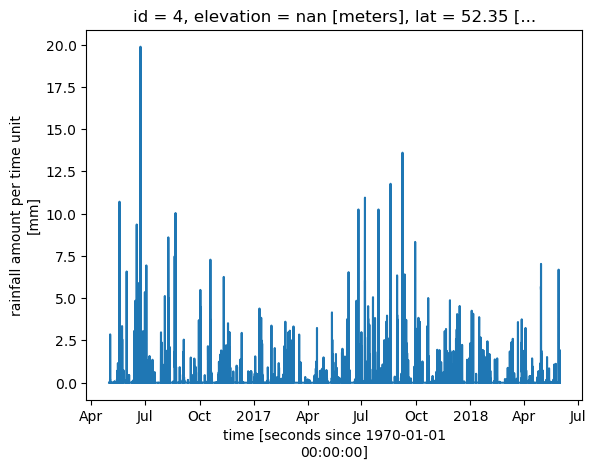

In [16]:
ref_id = str(closest_neighbor.neighbor_id.data[0][0])
ds_ref.sel(id=ref_id).rainfall.plot()

Plot time series for selected PWS

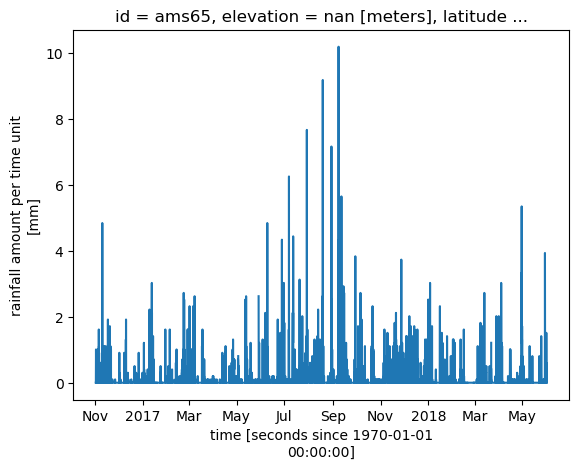

In [17]:
ds_pws.sel(id=pws_id).rainfall.plot()

Convert data to `np.array`

In [18]:
ref = ds_ref.sel(id=ref_id).rainfall.data
pws = ds_pws.sel(id=pws_id).rainfall.data

## Fitting data to a theoretical gamma function

Fit theoretical gamma function to the PWS and the reference data. Since rainfall data is higly skewed, we only fit the data above a certain threshold (here 1mm) and treat the values between 0mm and the threshold as censored values

Fit parameters for reference

In [19]:
shape_ref, scale_ref, p0_ref = bc.fit_gamma_with_threshold(ref, 1)
print(
    f"Optimal parameters: shape = {shape_ref:.5f}, scale = {scale_ref:.5f}, p0 = {p0_ref:.2f}"
)

Optimal parameters: shape = 0.26362, scale = 2.12160, p0 = 0.83


Fit parameters for PWS

In [20]:
shape_pws, scale_pws, p0_pws = bc.fit_gamma_with_threshold(pws, 1)
print(
    f"Optimal parameters: shape = {shape_pws:.5f}, scale = {scale_pws:.5f}, p0 = {p0_pws:.2f}"
)

Optimal parameters: shape = 0.49763, scale = 0.98254, p0 = 0.85


Do the bias correction using quantile mapping

In [21]:
pws_corr = bc.qq_gamma(pws, shape_pws, scale_pws, p0_pws, shape_ref, scale_ref, p0_ref)

Create a new `xr.Dataset` for the selected PWS

In [22]:
selected_pws = ds_pws.sel(id=pws_id)

In [23]:
selected_pws

<xarray.Dataset> Size: 292kB
Dimensions:    (time: 18265)
Coordinates:
    id         <U6 24B 'ams65'
    elevation  <U3 12B 'nan'
    latitude   float64 8B 52.35
    longitude  float64 8B 4.885
  * time       (time) datetime64[ns] 146kB 2016-05-01 ... 2018-06-01
    x          float64 8B 6.284e+05
    y          float64 8B 5.801e+06
Data variables:
    rainfall   (time) float64 146kB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 nan
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

Add the bias corrected values as new data variable to the existing `xr.Dataset`


In [24]:
var_dim = ds_pws.rainfall.shape
rainfall_bcorr = np.full(var_dim, np.nan)
# dimensions might be swapped which causes an error. Transpose (rainfall_bcorr.T) is a first fix for this
selected_pws["rainfall_biascorr"] = (selected_pws["rainfall"].dims, pws_corr)

Check for first valid entry in PWS rainfall data and define start and end dates for comparison plots

In [25]:
first_valid_index = selected_pws.rainfall.notnull().argmax(dim="time")
start_date = selected_pws.time.isel(time=first_valid_index)
end_date = str(selected_pws.time.data[-1])

Plot original and bias corrected cumulatice rainfall sums for the selected PWS

''

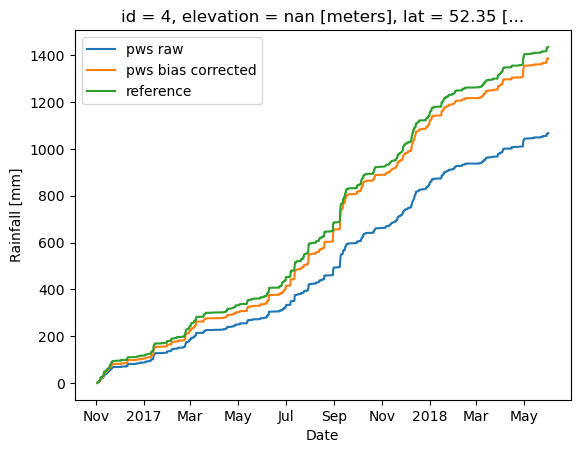

In [26]:
selected_pws.rainfall.sel(time=slice(start_date, end_date)).cumsum().plot(
    label="pws raw"
)
selected_pws.rainfall_biascorr.sel(time=slice(start_date, end_date)).cumsum().plot(
    label="pws bias corrected"
)
ds_ref.sel(id=ref_id).rainfall.sel(time=slice(start_date, end_date)).cumsum().plot(
    label="reference"
)
plt.legend()
plt.ylabel("Rainfall [mm]")
plt.xlabel("Date")
;

Plot Hexbinplot coparison with reference before and after bias correction

''

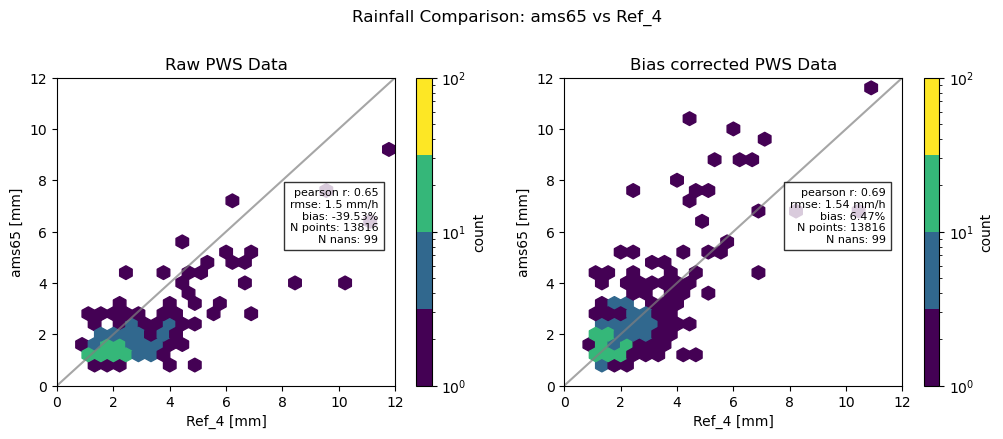

In [27]:
threshold = 1
da_pws_raw = selected_pws.rainfall.sel(time=slice(start_date, end_date)).data.flatten()[
    :-1
]
da_pws_biascorr = selected_pws.rainfall_biascorr.sel(
    time=slice(start_date, end_date)
).data.flatten()[:-1]
da_ref = (
    ds_ref.sel(id=ref_id).rainfall.sel(time=slice(start_date, end_date)).data.flatten()
)

rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=da_ref,
    estimate=da_pws_raw,
    ref_thresh=threshold,
    est_thresh=threshold,
)
rainfall_metrics_1 = plg.validation.calculate_rainfall_metrics(
    reference=da_ref,
    estimate=da_pws_biascorr,
    ref_thresh=threshold,
    est_thresh=threshold,
)
# plotting the scatter density plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f"Rainfall Comparison: {pws_id} vs Ref_{ref_id}", fontsize=12, y=1.05)
hx = plg.validation.plot_hexbin(
    da_ref,
    da_pws_raw,
    ref_thresh=threshold,
    est_thresh=threshold,
    # extent=[0,11,0,11],
    ax=ax[0],
)
ax[0].set_title("Raw PWS Data")
ax[0].set_xlabel("Ref_" + ref_id + " [mm]")
ax[0].set_ylabel(pws_id + " [mm]")
hx = plg.validation.plot_hexbin(
    da_ref,
    da_pws_biascorr,
    ref_thresh=threshold,
    est_thresh=threshold,
    # extent=[0,11,0,11],
    ax=ax[1],
)
ax[1].set_title("Bias corrected PWS Data")
ax[1].set_xlabel("Ref_" + ref_id + " [mm]")
ax[1].set_ylabel(pws_id + " [mm]")
# adding metrics to the plot for subplot 0
plotted_metrics = (
    f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
    f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
    f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
    f"N points: {rainfall_metrics['N_all']}\n"
    f"N nans: {rainfall_metrics['N_nan']}"
)
ax[0].text(
    0.95,
    0.55,
    plotted_metrics,
    fontsize=8,
    transform=ax[0].transAxes,
    verticalalignment="center",
    horizontalalignment="right",
    bbox={"facecolor": "white", "alpha": 0.8},
)
# adding metrics to the plot for subplot 1
plotted_metrics_1 = (
    f"pearson r: {np.round(rainfall_metrics_1['pearson_correlation_coefficient'], 2)}\n"
    f"rmse: {np.round(rainfall_metrics_1['root_mean_square_error'], 2)} mm/h\n"
    f"bias: {np.round(rainfall_metrics_1['percent_bias'], 2)}%\n"
    f"N points: {rainfall_metrics_1['N_all']}\n"
    f"N nans: {rainfall_metrics_1['N_nan']}"
)
ax[1].text(
    0.95,
    0.55,
    plotted_metrics_1,
    fontsize=8,
    transform=ax[1].transAxes,
    verticalalignment="center",
    horizontalalignment="right",
    bbox={"facecolor": "white", "alpha": 0.8},
)
ax[0].set_xlim(0, 12)
ax[0].set_ylim(0, 12)
ax[1].set_xlim(0, 12)
ax[1].set_ylim(0, 12)
# filename = f"bias_correction_thr_1mm{pws_id}.png"
# fig.savefig(filename, bbox_inches='tight', dpi=300)
# plt.close(fig)  # Close the figure to free memory
;